In [2]:
# from pytorch_tabnet.tab_model import TabNetClassifier
# from tabnet import TabNetClassifier
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import openpyxl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay,roc_curve,recall_score,precision_score,confusion_matrix,accuracy_score,mean_squared_error,explained_variance_score,f1_score,mean_absolute_error
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler,RobustScaler,PolynomialFeatures
import random
from sklearn.model_selection import train_test_split,KFold
import glob
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA,FastICA,FactorAnalysis
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,f_oneway,f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import keras
# import mat4py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import keras
from tensorflow.keras import initializers
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [4]:
for flavor in glob.glob("/content/drive/MyDrive/Tecvico Files/projects/Copy of P202203140002/Code and dataset/Version 1/Deep Features/modified_result/*.csv"):
    print (flavor)
    df = pd.read_csv(flavor)
    break

/content/drive/MyDrive/Tecvico Files/projects/Copy of P202203140002/Code and dataset/Version 1/Deep Features/modified_result/modified_result_ct_autoencoder3d.csv


In [9]:
names = []
for add in glob.glob("/content/drive/MyDrive/Tecvico Files/projects/Copy of P202203140002/Code and dataset/Version 1/Deep Features/modified_result/*.csv"):
    print(add.split("_")[3])
    names.append(add.split("_")[3])

ct
pet
F1
F2
F3
F4
F5
F6
F7
F8
F9
F10
F11
F12
F13
F14
HSI
PCA
wavedec
weighted


In [13]:
# one time run
whole_data = []
for add in glob.glob("/content/drive/MyDrive/Tecvico Files/projects/Copy of P202203140002/Code and dataset/Version 1/Deep Features/modified_result/*.csv"):
    flavor = pd.read_csv(add)
    
    flavor.sort_values("Unnamed: 0",axis=0,inplace= True)
    flavor.drop("Unnamed: 0",axis=1,inplace=True)
    whole_data.append(flavor.iloc[:408,:])



In [14]:
pca = PCA(0.99)

# Low stds are dropped and pca is calculated
for i in range(len(whole_data)):
    stds = pd.DataFrame(np.std(whole_data[i]))
    whole_data[i].drop(stds[stds[0]<0.01].index,axis=1,inplace=True)
    whole_data[i] = pd.DataFrame(pca.fit_transform(whole_data[i]))




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
all_labels = pd.read_excel("/content/drive/MyDrive/Tecvico Files/projects/Copy of P202203140002/Code and dataset/Version 1/Deep Features/Outcome_Data_HN_V06.xlsx")["Progression"]

In [16]:
# Resultrs on single flavor for 9 random forest
result_random_single = pd.DataFrame()
for g,df in enumerate(whole_data):
    data = df
    n = 9
    # results_poly_diff_neurons[l1] = {}
    # n = eval(input("n_estimators"))
    kf = KFold(n_splits=5,shuffle=True)

    count = 0
    lst_test = []
    lst_val = []
    lst_test_prob = []
    lst_val_prob = []
    # Iterating through each fold
    for train,test  in kf.split(data,all_labels):
        preds_test = pd.DataFrame()
        pred_val = pd.DataFrame()

        count+=1

        X = data.iloc[train]
        y = all_labels.iloc[train]
        X_test = data.iloc[test]
        y_test = all_labels.iloc[test]
        X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)
        pred_val_prob = np.zeros((len(y_validation),2),dtype=np.float32)
        pred_test_prob = np.zeros((y_test.shape[0],2),dtype=np.float32)
        for i in range(n):

        #     # Create model
            # model_knn = DecisionTreeClassifier()
            # model_knn = MLPClassifier((200,10),max_iter=200,early_stopping=True,solver="adam",learning_rate  = "adaptive",validation_fraction=0.2,n_iter_no_change=15)
            # model_knn = MLPClassifier((50,),early_stopping=True,max_iter=10000)
            model_knn = RandomForestClassifier()
        #     # train model with training data
            model_knn.fit(X_train,y_train)

        #     # evaluating model with validation data
            pred_val = pd.concat([pred_val,(pd.DataFrame(data={"Knn" : model_knn.predict(X_validation)}))],axis=1)
            y_pred_val_prob= model_knn.predict_proba(X_validation)
            pred_val_prob+= y_pred_val_prob


            # model_knn = MLPClassifier((50,),early_stopping=True,max_iter=10000)
            model_knn = RandomForestClassifier()
            # model_knn = DecisionTreeClassifier()
            model_knn.fit(X,y)

            preds_test = pd.concat([preds_test,(pd.DataFrame(model_knn.predict(X_test)))],axis=1)


            y_pred_test_prob= model_knn.predict_proba(X_test)
            pred_test_prob +=y_pred_test_prob
            # print(accuracy_score(y_test,preds_test))


        preds_test["sum"]= preds_test.transpose().apply(sum)

        preds_test["ensemble"] = preds_test["sum"].apply(lambda x: 0 if x<(n//2+1) else 1)

        pred_val["sum"]= pred_val.transpose().apply(sum)

        pred_val["ensemble"] = pred_val["sum"].apply(lambda x: 0 if x<(n//2+1) else 1)

        acc_test = accuracy_score(y_test,preds_test["ensemble"].to_numpy())
        acc_val = accuracy_score(y_validation,pred_val["ensemble"].to_numpy())

        lst_test.append(acc_test)
        lst_val.append(acc_val)

        pred_val_prob /=n
        pred_test_prob/=n
        # pred_val_prob.argmax(axis=-1)
        # pred_test_prob.argmax(axis=-1)
        p1 = [0 if n > 0.5 else 1 for n in pred_test_prob[:,0] ]
        p2 = [0 if n > 0.5 else 1 for n in pred_val_prob[:,0] ]

        # acc_test_prob = accuracy_score(y_test,pred_test_prob.argmax(axis=-1))
        # acc_val_prob = accuracy_score(y_validation,pred_val_prob.argmax(axis=-1))
        acc_test_prob = accuracy_score(y_test,p1)
        acc_val_prob = accuracy_score(y_validation,p2)

        lst_test_prob.append(acc_test_prob)
        lst_val_prob.append(acc_val_prob)
        
        
    result_random_single = pd.concat([result_random_single,pd.DataFrame(data = {"data":[names[g]]*5,"Test Results": lst_test ,"Validation Results":lst_val ,"Test Results_prob": lst_test_prob ,"Validation Results_prob":lst_val_prob })],axis=0)
    # results_poly_diff_neurons[l1]["TR"] = lst_test
    # results_poly_diff_neurons[l1]["VR"] = lst_val
    # results_poly_diff_neurons[l1]["TRp"] = lst_test_prob
    # results_poly_diff_neurons[l1]["VRp"] = lst_val_prob
    # # print(ll)
    # print(l1)
    # Json = json.dumps(results_poly_diff_estimators)

    # # open file for writing, "w" 
    # f = open("results_poly_diff_neurons_3estimators_trf211.json","w")

    # # write json object to file
    # f.write(Json)

    # # close file
    # f.close()


In [17]:
result_random_single.to_excel("/content/drive/MyDrive/Tecvico Files/projects/Copy of P202203140002/Code and dataset/Version 1/Deep Features/result_random_single.xlsx",index=False)

In [18]:
# Resultrs on single flavor for 9 Logistic regression
result_log_single = pd.DataFrame()
for g,df in enumerate(whole_data):
    data = df
    n = 9
    # results_poly_diff_neurons[l1] = {}
    # n = eval(input("n_estimators"))
    kf = KFold(n_splits=5,shuffle=True)

    count = 0
    lst_test = []
    lst_val = []
    lst_test_prob = []
    lst_val_prob = []
    # Iterating through each fold
    for train,test  in kf.split(data,all_labels):
        preds_test = pd.DataFrame()
        pred_val = pd.DataFrame()

        count+=1

        X = data.iloc[train]
        y = all_labels.iloc[train]
        X_test = data.iloc[test]
        y_test = all_labels.iloc[test] 
        X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)
        pred_val_prob = np.zeros((len(y_validation),2),dtype=np.float32)
        pred_test_prob = np.zeros((y_test.shape[0],2),dtype=np.float32)
        for i in range(n):

        #     # Create model
            # model_knn = DecisionTreeClassifier()
            # model_knn = MLPClassifier((200,10),max_iter=200,early_stopping=True,solver="adam",learning_rate  = "adaptive",validation_fraction=0.2,n_iter_no_change=15)
            # model_knn = MLPClassifier((50,),early_stopping=True,max_iter=10000)
            model_knn = LogisticRegression(max_iter=10000)
        #     # train model with training data
            model_knn.fit(X_train,y_train)

        #     # evaluating model with validation data
            pred_val = pd.concat([pred_val,(pd.DataFrame(data={"Knn" : model_knn.predict(X_validation)}))],axis=1)
            y_pred_val_prob= model_knn.predict_proba(X_validation)
            pred_val_prob+= y_pred_val_prob


            # model_knn = MLPClassifier((50,),early_stopping=True,max_iter=10000)
            model_knn = LogisticRegression(max_iter=10000)
            # model_knn = DecisionTreeClassifier()
            model_knn.fit(X,y)

            preds_test = pd.concat([preds_test,(pd.DataFrame(model_knn.predict(X_test)))],axis=1)


            y_pred_test_prob= model_knn.predict_proba(X_test)
            pred_test_prob +=y_pred_test_prob
            # print(accuracy_score(y_test,preds_test))


        preds_test["sum"]= preds_test.transpose().apply(sum)

        preds_test["ensemble"] = preds_test["sum"].apply(lambda x: 0 if x<(n//2+1) else 1)

        pred_val["sum"]= pred_val.transpose().apply(sum)

        pred_val["ensemble"] = pred_val["sum"].apply(lambda x: 0 if x<(n//2+1) else 1)

        acc_test = accuracy_score(y_test,preds_test["ensemble"].to_numpy())
        acc_val = accuracy_score(y_validation,pred_val["ensemble"].to_numpy())

        lst_test.append(acc_test)
        lst_val.append(acc_val)

        pred_val_prob /=n
        pred_test_prob/=n
        # pred_val_prob.argmax(axis=-1)
        # pred_test_prob.argmax(axis=-1)
        p1 = [0 if n > 0.5 else 1 for n in pred_test_prob[:,0] ]
        p2 = [0 if n > 0.5 else 1 for n in pred_val_prob[:,0] ]

        # acc_test_prob = accuracy_score(y_test,pred_test_prob.argmax(axis=-1))
        # acc_val_prob = accuracy_score(y_validation,pred_val_prob.argmax(axis=-1))
        acc_test_prob = accuracy_score(y_test,p1)
        acc_val_prob = accuracy_score(y_validation,p2)

        lst_test_prob.append(acc_test_prob)
        lst_val_prob.append(acc_val_prob)
        
        
    result_log_single = pd.concat([result_log_single,pd.DataFrame(data = {"data":[names[g]]*5,"Test Results": lst_test ,"Validation Results":lst_val ,"Test Results_prob": lst_test_prob ,"Validation Results_prob":lst_val_prob })],axis=0)
    # results_poly_diff_neurons[l1]["TR"] = lst_test
    # results_poly_diff_neurons[l1]["VR"] = lst_val
    # results_poly_diff_neurons[l1]["TRp"] = lst_test_prob
    # results_poly_diff_neurons[l1]["VRp"] = lst_val_prob
    # # print(ll)
    # print(l1)
    # Json = json.dumps(results_poly_diff_estimators)

    # # open file for writing, "w" 
    # f = open("results_poly_diff_neurons_3estimators_trf211.json","w")

    # # write json object to file
    # f.write(Json)

    # # close file
    # f.close()


In [19]:
result_log_single.to_excel("/content/drive/MyDrive/Tecvico Files/projects/Copy of P202203140002/Code and dataset/Version 1/Deep Features/result_log_single.xlsx",index=False)

In [20]:
# Resultrs on single flavor for 9 mlp
result_mlp_single = pd.DataFrame()
for g,df in enumerate(whole_data):
    data = df
    n = 5
    # results_poly_diff_neurons[l1] = {}
    # n = eval(input("n_estimators"))
    kf = KFold(n_splits=5,shuffle=True)

    count = 0
    lst_test = []
    lst_val = []
    lst_test_prob = []
    lst_val_prob = []
    # Iterating through each fold
    for train,test  in kf.split(data,all_labels):
        preds_test = pd.DataFrame()
        pred_val = pd.DataFrame()

        count+=1

        X = data.iloc[train]
        y = all_labels.iloc[train]
        X_test = data.iloc[test]
        y_test = all_labels.iloc[test] 
        X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)
        pred_val_prob = np.zeros((len(y_validation),2),dtype=np.float32)
        pred_test_prob = np.zeros((y_test.shape[0],2),dtype=np.float32)
        for i in range(n):

        #     # Create model
            # model_knn = DecisionTreeClassifier()
            # model_knn = MLPClassifier((200,10),max_iter=200,early_stopping=True,solver="adam",learning_rate  = "adaptive",validation_fraction=0.2,n_iter_no_change=15)
            # model_knn = MLPClassifier((50,),early_stopping=True,max_iter=10000)
            model_knn = MLPClassifier((50,),early_stopping=False,max_iter=10000)
        #     # train model with training data
            model_knn.fit(X_train,y_train)

        #     # evaluating model with validation data
            pred_val = pd.concat([pred_val,(pd.DataFrame(data={"Knn" : model_knn.predict(X_validation)}))],axis=1)
            y_pred_val_prob= model_knn.predict_proba(X_validation)
            pred_val_prob+= y_pred_val_prob


            # model_knn = MLPClassifier((50,),early_stopping=True,max_iter=10000)
            model_knn = MLPClassifier((50,),early_stopping=False,max_iter=10000)
            # model_knn = DecisionTreeClassifier()
            model_knn.fit(X,y)

            preds_test = pd.concat([preds_test,(pd.DataFrame(model_knn.predict(X_test)))],axis=1)


            y_pred_test_prob= model_knn.predict_proba(X_test)
            pred_test_prob +=y_pred_test_prob
            # print(accuracy_score(y_test,preds_test))


        preds_test["sum"]= preds_test.transpose().apply(sum)

        preds_test["ensemble"] = preds_test["sum"].apply(lambda x: 0 if x<(n//2+1) else 1)

        pred_val["sum"]= pred_val.transpose().apply(sum)

        pred_val["ensemble"] = pred_val["sum"].apply(lambda x: 0 if x<(n//2+1) else 1)

        acc_test = accuracy_score(y_test,preds_test["ensemble"].to_numpy())
        acc_val = accuracy_score(y_validation,pred_val["ensemble"].to_numpy())

        lst_test.append(acc_test)
        lst_val.append(acc_val)

        pred_val_prob /=n
        pred_test_prob/=n
        # pred_val_prob.argmax(axis=-1)
        # pred_test_prob.argmax(axis=-1)
        p1 = [0 if n > 0.5 else 1 for n in pred_test_prob[:,0] ]
        p2 = [0 if n > 0.5 else 1 for n in pred_val_prob[:,0] ]

        # acc_test_prob = accuracy_score(y_test,pred_test_prob.argmax(axis=-1))
        # acc_val_prob = accuracy_score(y_validation,pred_val_prob.argmax(axis=-1))
        acc_test_prob = accuracy_score(y_test,p1)
        acc_val_prob = accuracy_score(y_validation,p2)

        lst_test_prob.append(acc_test_prob)
        lst_val_prob.append(acc_val_prob)
        
    print(names[g])
    result_mlp_single = pd.concat([result_mlp_single,pd.DataFrame(data = {"data":[names[g]]*5,"Test Results": lst_test ,"Validation Results":lst_val ,"Test Results_prob": lst_test_prob ,"Validation Results_prob":lst_val_prob })],axis=0)
    # results_poly_diff_neurons[l1]["TR"] = lst_test
    # results_poly_diff_neurons[l1]["VR"] = lst_val
    # results_poly_diff_neurons[l1]["TRp"] = lst_test_prob
    # results_poly_diff_neurons[l1]["VRp"] = lst_val_prob
    # # print(ll)
    # print(l1)
    # Json = json.dumps(results_poly_diff_estimators)

    # # open file for writing, "w" 
    # f = open("results_poly_diff_neurons_3estimators_trf211.json","w")

    # # write json object to file
    # f.write(Json)

    # # close file
    # f.close()


ct
pet
F1
F2
F3
F4
F5
F6
F7
F8
F9
F10
F11
F12
F13
F14
HSI
PCA
wavedec
weighted


In [21]:
result_mlp_single.to_excel("/content/drive/MyDrive/Tecvico Files/projects/Copy of P202203140002/Code and dataset/Version 1/Deep Features/result_mlp_single.xlsx",index=False)

In [ ]:
results = pd.read_excel("all_results.xlsx")

In [ ]:
import matplotlib as mpl

In [ ]:
results["data"] = results["data"].apply(lambda x: {"ct":"CT","pet":"PET","weighted": "WEIGHTED","wavedec":"WAVEDEC","F1":"LP","F2":"RP","F3":"DWT",
             "F4":"DTCWT" , "F5": "CVT","F6":"NSCT","F7":"LP+SR","F11":"CVT+SR","F12":"NSCT+SR","F13":"SR","F14":"BCF","HSI":"HSI","PCA":"PCA",
             "TR-FF":"TR-FF","TR-PCA":"TR-PCA","Combined":"combined"}[x])

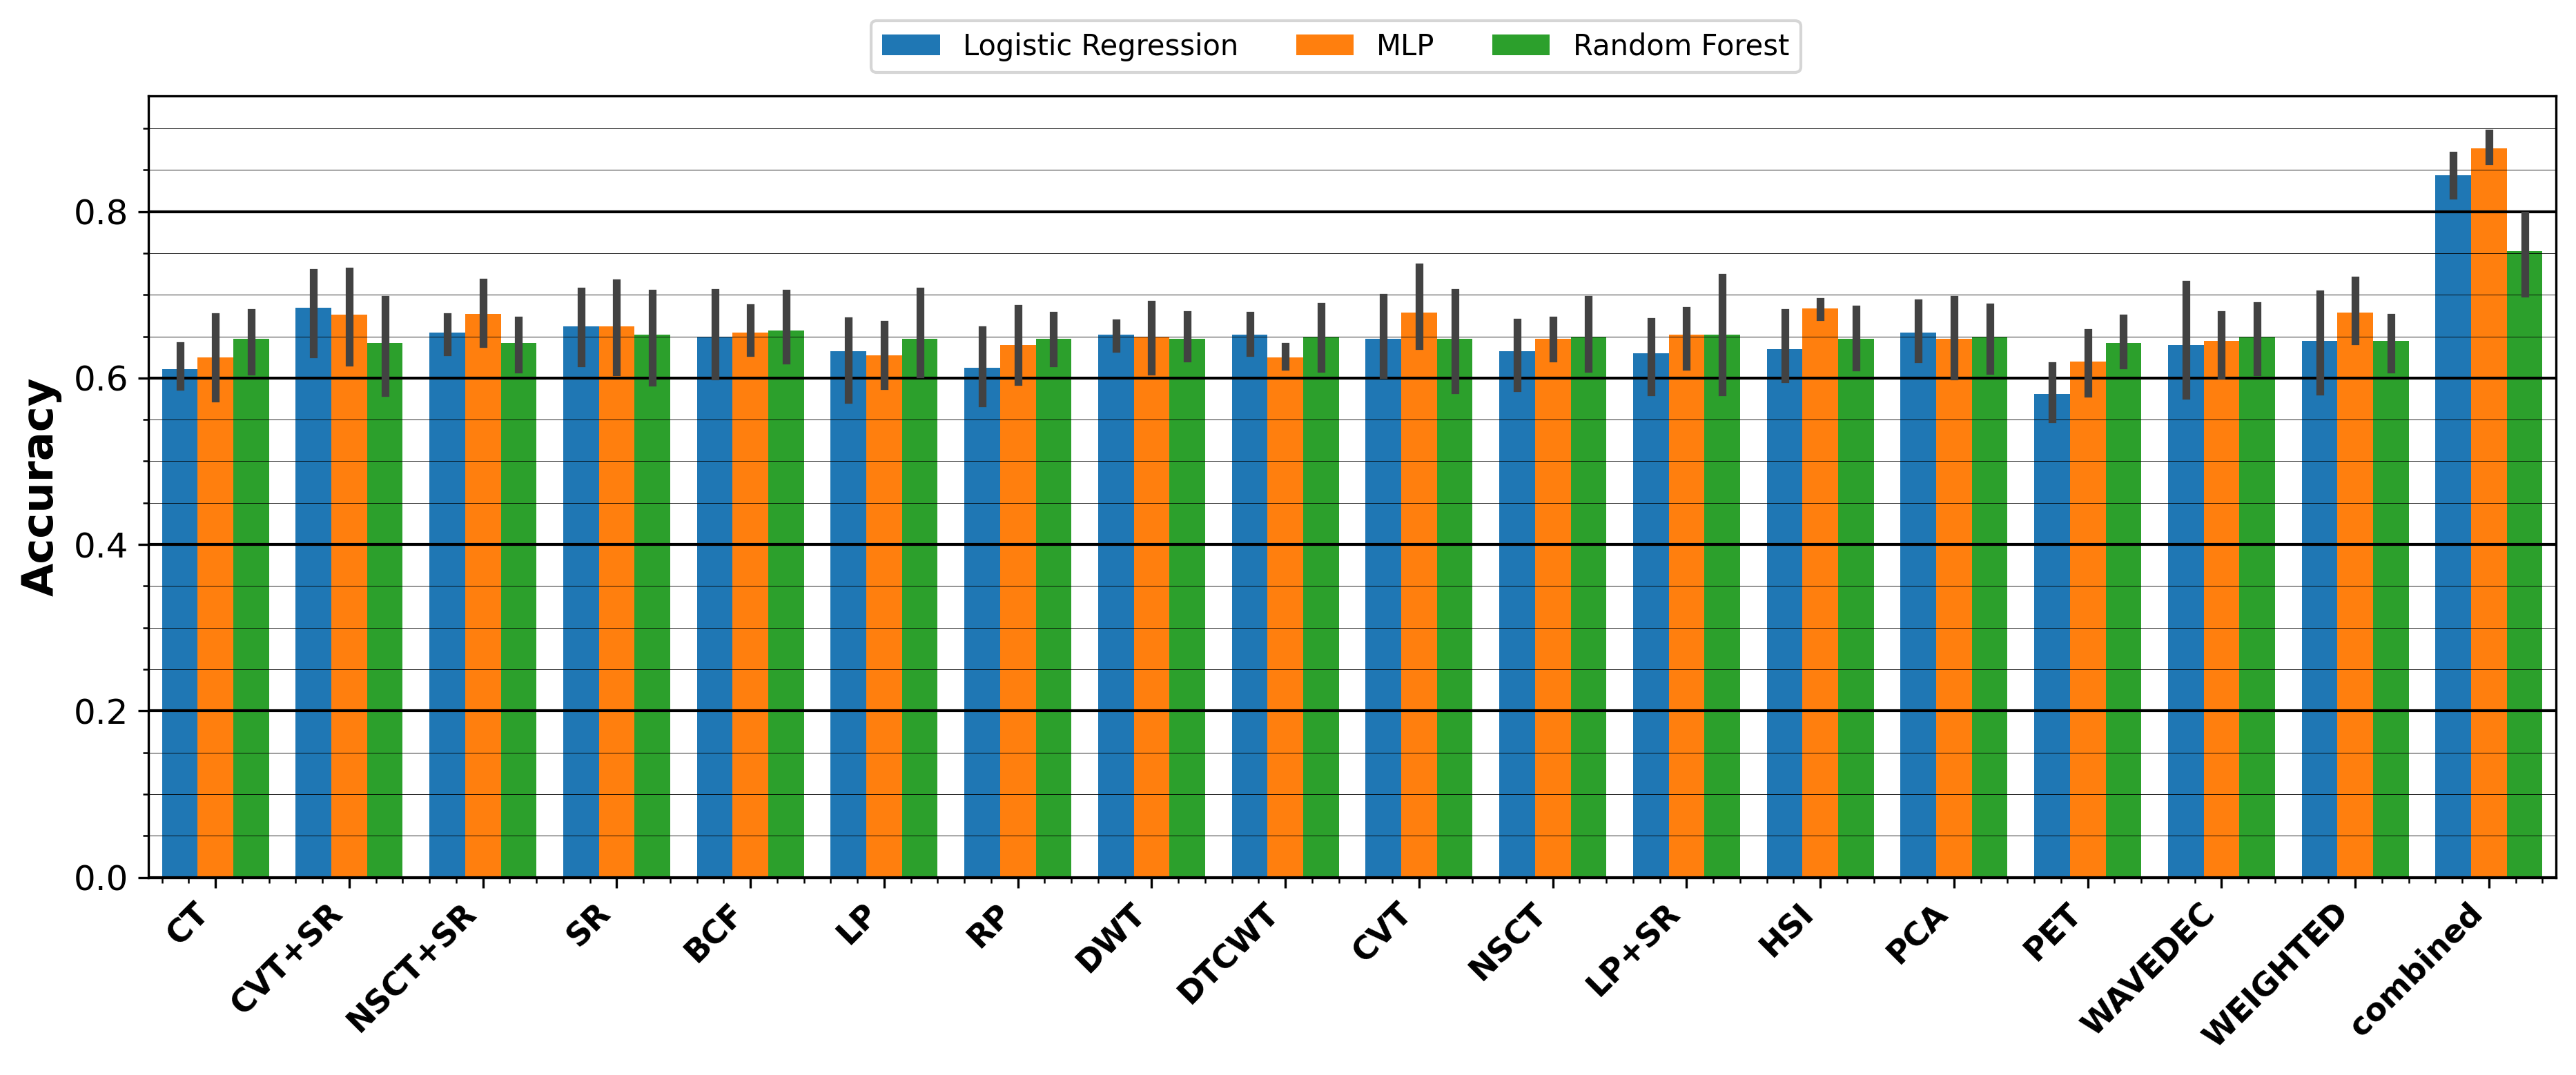

In [ ]:
# ACC SCORE
fi,axes = plt.subplots(1,1,figsize = (15,5),dpi = 300)
ax =sns.barplot(data=results, x = "data" , y = "Test Results",hue= "Model",palette= "tab10" ,ax = axes,saturation=2)
# ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid( which='major', color='black', linewidth=1.0,axis = "y")
ax.grid( which='minor', color='black', linewidth=0.2,axis = "y")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=11,fontweight = "bold")
ax.legend(loc = (0.3,1.03),ncol=4)
ax.set_xlabel("")
ax.set_ylabel("Accuracy",fontweight = "bold",fontsize = 15)
ax.yaxis.set_tick_params(labelsize=12)
plt.savefig("Test_Acc_scores_rf211.jpg",bbox_inches = "tight")